# 베이지안 회귀 분석 예제

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import pymc3 as pm
import numpy as np
np.random.seed(1000)
import matplotlib as mpl
import matplotlib.pyplot as plt

## 단순 선형 회귀 

* `np.polyfit` 명령으로 단순 선형 회귀 가능

In [3]:
x = np.linspace(0, 10, 500)
y = 4 + 2 * x + np.random.standard_normal(len(x)) * 2

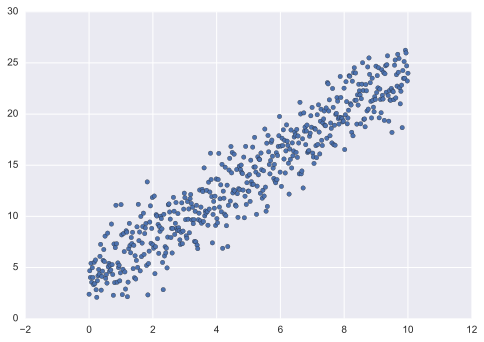

In [4]:
plt.scatter(x, y)
plt.show()

In [5]:
reg = np.polyfit(x, y, 1)
reg

array([ 2.03384161,  3.77649234])

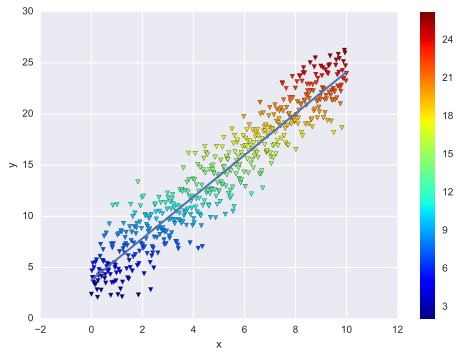

In [6]:
plt.scatter(x, y, c=y, marker='v', cmap=mpl.cm.jet)
plt.plot(x, reg[1] + reg[0] * x, lw=2.0)
plt.colorbar()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## 베이지안 회귀

In [7]:
with pm.Model() as model: 
        # PyMC3의 모형은 with 문 안에서 사용된다.
    # 사전 확률 정의
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    # 선형 회귀선 정의
    y_est = alpha + beta * x
    
    # 우도 정의 
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)
    
    # 추정 과정
    start = pm.find_MAP()
      # 최적화를 사용하여 시작값 추정
    step = pm.NUTS(state=start)
      # MCMC 샘플링 알고리즘 인스턴스 생성
    trace = pm.sample(100, step, start=start, progressbar=False)
      # NUTS 샘플링을 사용하여 100개의 사후 샘플 생성

Applied interval-transform to sigma and added transformed sigma_interval to model.


In [8]:
trace[0]

{'alpha': 3.6753933701475208,
 'beta': 2.0269126776713682,
 'sigma': 2.0646947235522579,
 'sigma_interval_': -1.346339443526801}

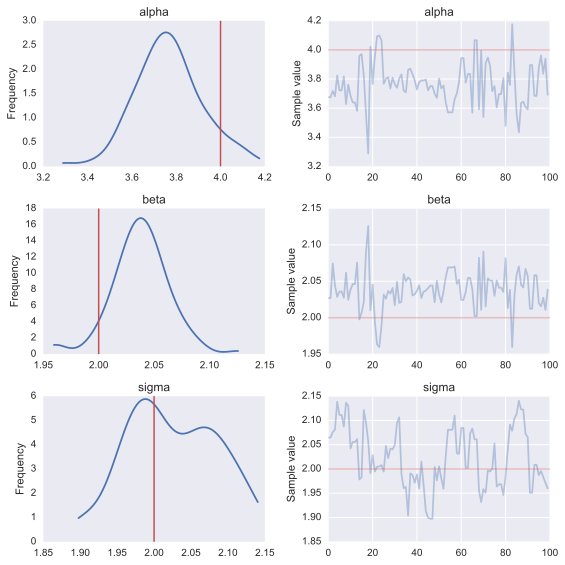

In [9]:
pm.traceplot(trace, lines={'alpha': 4, 'beta': 2, 'sigma': 2}, figsize=(8, 8))
plt.show()

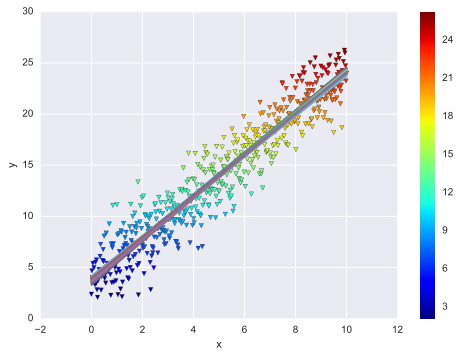

In [10]:
plt.scatter(x, y, c=y, marker='v', cmap=mpl.cm.jet)
plt.colorbar()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
for i in range(len(trace)):
    plt.plot(x, trace['alpha'][i] + trace['beta'][i] * x)

## 실제 주가의 회귀 관계 변화

In [11]:
import zipline
import pytz
import datetime as dt

In [12]:
data = zipline.data.load_from_yahoo(stocks=['GLD', 'GDX'], 
         end=dt.datetime(2014, 3, 15, 0, 0, 0, 0, pytz.utc)).dropna()
data.tail()

,GDX,GLD
Date,,
2014-03-10 00:00:00+00:00,25.580999,129.130005
2014-03-11 00:00:00+00:00,25.738602,129.860001
2014-03-12 00:00:00+00:00,26.516770,131.759995
2014-03-13 00:00:00+00:00,27.216134,132.210007
2014-03-14 00:00:00+00:00,27.314637,133.100006


In [13]:
len(data)

1967

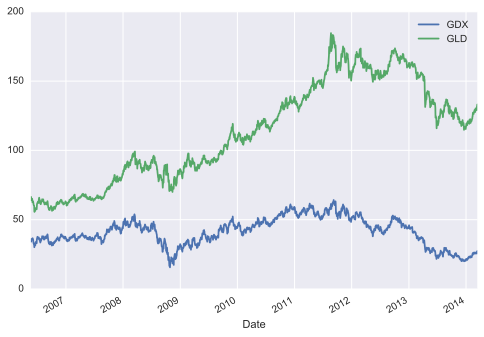

In [14]:
data.plot()
plt.show()

In [15]:
import matplotlib as mpl
mpl_dates = mpl.dates.date2num(data.index.to_pydatetime())
mpl_dates

array([ 732453.,  732454.,  732455., ...,  735304.,  735305.,  735306.])

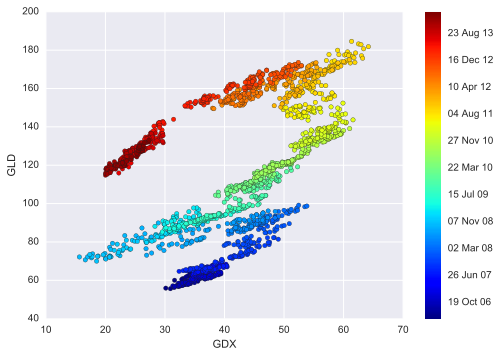

In [16]:
plt.scatter(data['GDX'], data['GLD'], c=mpl_dates, marker='o', cmap=mpl.cm.jet)
plt.grid(True)
plt.xlabel('GDX')
plt.ylabel('GLD')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250),
             format=mpl.dates.DateFormatter('%d %b %y'))
plt.show()

In [17]:
from pymc3.distributions import Exponential
model_randomwalk = pm.Model()
with model_randomwalk:
    sigma_alpha = Exponential('sigma_alpha', 1. / .02, testval=.1)
    sigma_beta = Exponential('sigma_beta', 1. / .02, testval=.1)

Applied log-transform to sigma_alpha and added transformed sigma_alpha_log to model.
Applied log-transform to sigma_beta and added transformed sigma_beta_log to model.


In [18]:
from pymc3.distributions.timeseries import GaussianRandomWalk

subsample_alpha = 50
subsample_beta = 50

with model_randomwalk:
    alpha = GaussianRandomWalk('alpha', sigma_alpha**-2, shape=len(data) // subsample_alpha)
    beta = GaussianRandomWalk('beta', sigma_beta**-2, shape=len(data) // subsample_beta)
    alpha_r = np.repeat(alpha, subsample_alpha)
    beta_r = np.repeat(beta, subsample_beta)

In [19]:
len(data.dropna().GDX.values) 

1967

In [20]:
with model_randomwalk:
    regression = alpha_r + beta_r * data.GDX.values[:1950]
    sd = pm.Uniform('sd', 0, 20)
    likelihood = pm.Normal('GLD', 
                           mu=regression, 
                           sd=sd, 
                           observed=data.GLD.values[:1950])

Applied interval-transform to sd and added transformed sd_interval to model.


In [21]:
import scipy.optimize as sco
with model_randomwalk:
    start = pm.find_MAP(vars=[alpha, beta], fmin=sco.fmin_l_bfgs_b)
    step = pm.NUTS(scaling=start)
    trace_rw = pm.sample(100, step, start=start, progressbar=False)

In [22]:
part_dates = np.linspace(min(mpl_dates), max(mpl_dates), 39)

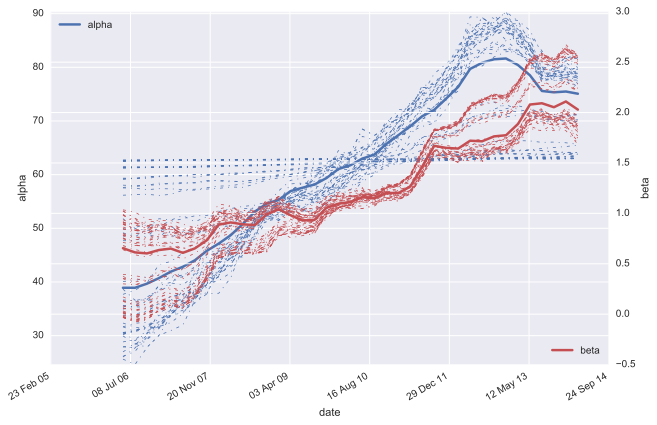

In [23]:
fig, ax1 = plt.subplots(figsize=(10, 7))
plt.plot(part_dates, np.mean(trace_rw['alpha'], axis=0), 'b', lw=2.5, label='alpha')
for i in range(55):
    plt.plot(part_dates, trace_rw['alpha'][i], 'b-.', lw=0.75)
plt.xlabel('date')
plt.ylabel('alpha')
plt.axis('tight')
plt.grid(True)
plt.legend(loc=2)
ax1.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d %b %y') )
ax2 = ax1.twinx()
plt.plot(part_dates, np.mean(trace_rw['beta'], axis=0), 'r', lw=2.5, label='beta')
for i in range(55):
    plt.plot(part_dates, trace_rw['beta'][i], 'r-.', lw=0.75)
plt.ylabel('beta')
plt.legend(loc=4)
fig.autofmt_xdate()
plt.show()

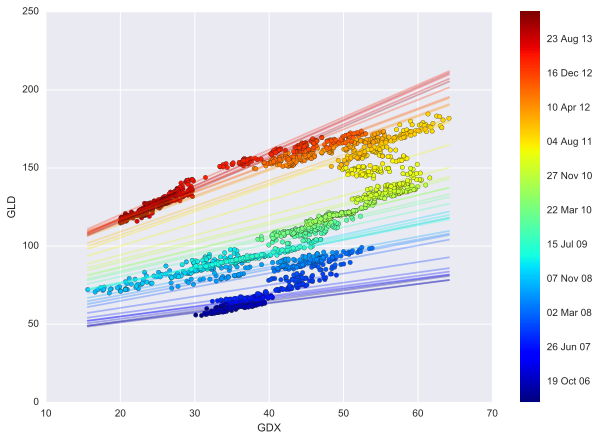

In [24]:
plt.figure(figsize=(10,7))
plt.scatter(data['GDX'], data['GLD'], c=mpl_dates, marker='o', cmap=mpl.cm.jet)
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250),
             format=mpl.dates.DateFormatter('%d %b %y'))
plt.grid(True)
plt.xlabel('GDX')
plt.ylabel('GLD')
x = np.linspace(min(data['GDX']), max(data['GDX'])) 
for i in range(39):
    alpha_rw = np.mean(trace_rw['alpha'].T[i])
    beta_rw = np.mean(trace_rw['beta'].T[i]) 
    plt.plot(x, alpha_rw + beta_rw * x, alpha=0.3,
             color=plt.cm.jet(256 * i // 39))
plt.show()    